# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# pyro & pytorch
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist

from sklearn.metrics import matthews_corrcoef as mcc

# loading & saving data
from scipy.io import loadmat
import pandas as pd
import os
import time
import datetime
import pickle
import inspect

# gui
import qgrid
qgrid.enable()
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import math


pyro.enable_validation(True)

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["font.size"] = 16
plt.rcParams["font.size"]

16.0

In [3]:
def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

## Enable Cuda

In [4]:
#device = torch.device("cuda:0")
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
#torch.cuda.is_available()

# Explore Data

In [84]:
sample_info = pd.DataFrame(data={"dx": np.zeros((1000,)), "dy": np.zeros((1000,))})
len(sample_info)

1000

In [88]:
from gammamodel import GammaNoise

pyro.clear_param_store()
gmm = GammaNoise(data=None, info=sample_info, D=10, K=3)

In [89]:
pyro.clear_param_store()

pyro.param("weights_conc", torch.tensor([720., 250., 30.]), constraint=constraints.positive)

pyro.param("gain_delta", torch.tensor(13.), constraint=constraints.positive)

pyro.param("height_loc", torch.tensor(80.), constraint=constraints.positive)
pyro.param("height_scale", torch.tensor(1.), constraint=constraints.positive)

pyro.param("height2_loc", torch.tensor(180.), constraint=constraints.positive)
pyro.param("height2_scale", torch.tensor(1.), constraint=constraints.positive)

#pyro.param("height3_loc", torch.tensor(150.), constraint=constraints.positive)
#pyro.param("height3_scale", torch.tensor(1.), constraint=constraints.positive)

pyro.param("background_loc", torch.tensor(160.), constraint=constraints.positive)
pyro.param("background_scale", torch.tensor(1.), constraint=constraints.positive)

pyro.param("width_delta", torch.tensor(1.3), constraint=constraints.positive)

pyro.param("width2_delta", torch.tensor(1.5), constraint=constraints.positive)

#pyro.param("width3_delta", torch.tensor(1.5), constraint=constraints.positive)

pyro.param("offset_delta", torch.tensor(90.), constraint=constraints.interval(0, 100))

pyro.param("x_delta", torch.tensor(4.5))
pyro.param("y_delta", torch.tensor(4.5))

pyro.param("z_probs", torch.tensor([0.72, 0.25, 0.03]).expand([1000, 3]), constraint=constraints.simplex)

for p in pyro.get_param_store().get_all_param_names():
    print(pyro.param(p))

tensor([720.0001, 250.0000,  30.0000], grad_fn=<AddBackward0>)
tensor(13.0000, grad_fn=<AddBackward0>)
tensor(80., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(180.0000, grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(160., grad_fn=<AddBackward0>)
tensor(1., grad_fn=<AddBackward0>)
tensor(1.3000, grad_fn=<AddBackward0>)
tensor(1.5000, grad_fn=<AddBackward0>)
tensor(90., grad_fn=<AddBackward0>)
tensor(4.5000, requires_grad=True)
tensor(4.5000, requires_grad=True)
tensor([[0.7200, 0.2500, 0.0300],
        [0.7200, 0.2500, 0.0300],
        [0.7200, 0.2500, 0.0300],
        ...,
        [0.7200, 0.2500, 0.0300],
        [0.7200, 0.2500, 0.0300],
        [0.7200, 0.2500, 0.0300]], grad_fn=<DivBackward0>)


In [90]:
sample_data, sample_z = gmm.sample(1000)

In [91]:
gmm.data = sample_data

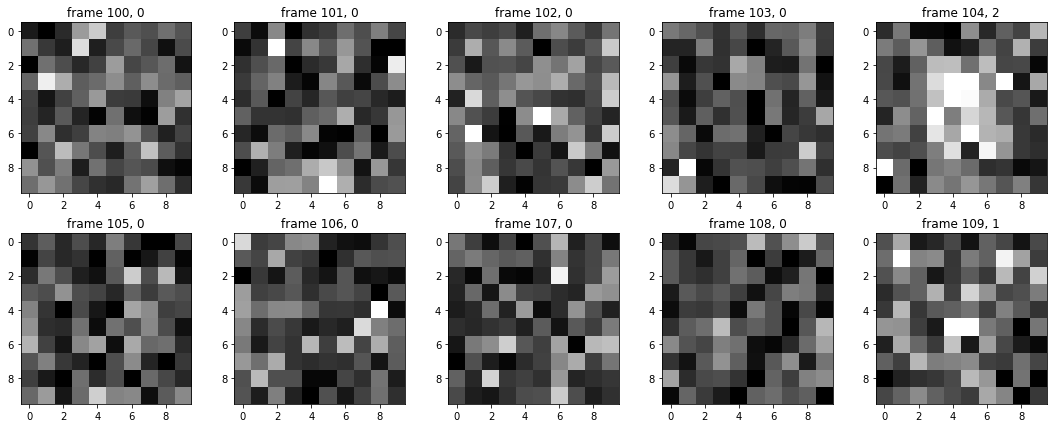

In [93]:
plt.figure(figsize=(15,6))
frame = 100
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title("frame {:d}, {}".format(frame+i, sample_z[frame+i]))
    vmin = np.percentile(sample_data.detach(), 5)
    vmax = np.percentile(sample_data.detach(), 99)
    plt.imshow(sample_data[frame+i].detach(), cmap='gray', vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

# Train the model

In [ ]:
# load checkpoint
optim.load("checkpoints/gmm_aoi17_optim_2019-06-24_10:01:04.ckpt")
pyro.get_param_store().load("checkpoints/gmm_aoi17_param_2019-06-24_10:01:04.ckpt")
history = load_obj("checkpoints/gmm_aoi17_history_2019-06-24_10:01:04.pkl")

In [99]:
pyro.clear_param_store()
batch_size = 256

def per_param_callable(module_name, param_name):
    if param_name in ["offset_delta", "background_loc", "background_scale", "height_loc", "gain_delta"]:
        return {"lr": 0.2, 'betas': [0.9, 0.999]}
    else:
        return {"lr": 0.05, 'betas': [0.9, 0.999]}
#optim = pyro.optim.ASGD({"lr":0.1})
optim = pyro.optim.Adam(per_param_callable)
elbo = TraceEnum_ELBO()
#elbo = Trace_ELBO()
svi = SVI(gmm.model, gmm.guide, optim, loss=elbo)

In [100]:
history = {}
history["code"] = inspect.getsource(GammaNoise)
#history["trace"] = smd["trace"][aoi]
history["batch_size"] = batch_size
history["losses"] = [svi.evaluate_loss(batch_size)]
for p in pyro.get_param_store().get_all_param_names():
    if p in ["weights_conc", "z_probs"]:
        history[p] = [pyro.param(p)]
    else:
        history[p] = [pyro.param(p).item()]

TypeError: gaussian_spot() takes 7 positional arguments but 9 were given

In [96]:
n_steps = 1000
for i in range(n_steps):
    loss = svi.step(batch_size)
    history["losses"].append(loss)
    for p in pyro.get_param_store().get_all_param_names():
        if p in ["weights_conc", "z_probs"]:
            history[p].append(pyro.param(p))
        else:
            history[p].append(pyro.param(p).item())
    print("" if i % int(n_steps/100) else ".", end="")
    
save_obj(history, os.path.join("checkpoints", "last.pkl"))

....................................................................................................

In [42]:
# save checkpoint
st = datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d_%H:%M:%S')
optim.save("checkpoints/{}_aoi{}_optim_{}.ckpt".format(gmm.name, aoi, st))
pyro.get_param_store().save("checkpoints/{}_aoi{}_param_{}.ckpt".format(gmm.name, aoi, st))
save_obj(history, "checkpoints/{}_aoi{}_history_{}.pkl".format(gmm.name, aoi, st))

In [114]:
history["losses"][-1]

455424.09375

In [119]:
smd["data"][aoi].min()

tensor(185.)

In [21]:
history["weights_conc"][0][2]

tensor(10., grad_fn=<SelectBackward>)

In [77]:
%matplotlib inline

@interact
def view_history(filename=[file for file in os.listdir(os.path.join("checkpoints")) if file.endswith(".pkl")]):
    history = load_obj(os.path.join("checkpoints", "last.pkl"))
    rows = math.ceil(len(history)/3)
    plt.figure(figsize=(15,4*rows))
    i = 1
    for p in history.keys():
        if p == "weights_conc":
            plt.subplot(rows,3,i)
            plt.plot([w[0] for w in history[p]])
            plt.plot([w[1] for w in history[p]])
            plt.plot([w[2] for w in history[p]])
            plt.xlabel("iters")
            plt.title(p)
            i += 1
        elif p not in ["code", "trace", "batch_size", "z_probs"]:
            plt.subplot(rows,3,i)
            plt.plot(history[p])
            plt.xlabel("iters")
            plt.title(p)
            i += 1
        elif p == "z_probs":
            plt.subplot(rows,3,i)
            plt.plot([w[40,0] for w in history[p]])
            plt.plot([w[40,1] for w in history[p]])
            plt.plot([w[40,2] for w in history[p]])
            plt.xlabel("iters")
            plt.title(p)
            i += 1

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='filename', options=('gmm_aoi22_history_2019-06-24_08:55:00.pkl', '…

In [30]:
pyro.param("z_probs").shape

torch.Size([1000, 3])

# Fitting results

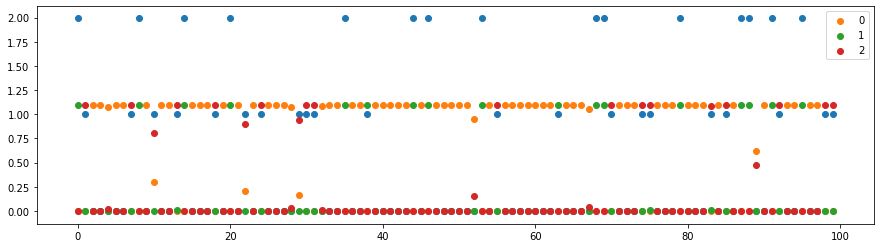

In [78]:
plt.figure(figsize=(15,4))
plt.scatter(np.arange(100) ,sample_z[:100].numpy())
plt.scatter(np.arange(100), pyro.param("z_probs").detach()[:100,0]*1.1, label="0")
plt.scatter(np.arange(100), pyro.param("z_probs").detach()[:100,1]*1.1, label="1")
plt.scatter(np.arange(100), pyro.param("z_probs").detach()[:100,2]*1.1, label="2")
plt.legend()
plt.show()

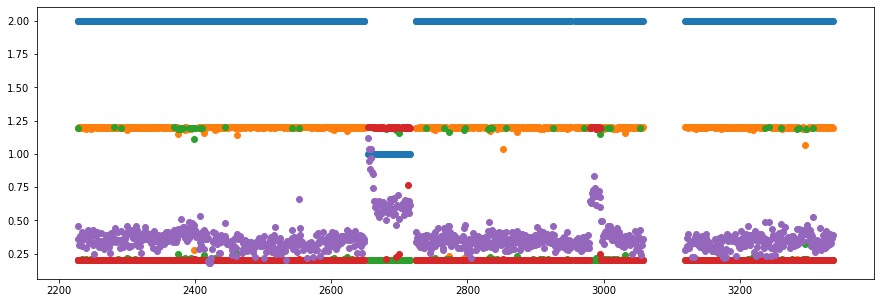

In [293]:
plt.figure(figsize=(15,5))
plt.scatter(framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["detected"] > 0), "frame"], framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["detected"] > 0), "detected"])
plt.scatter(smd["trace"][aoi].index, smd["trace"][aoi]["z0"]+0.2)
plt.scatter(smd["trace"][aoi].index, smd["trace"][aoi]["z1"]+0.2)
plt.scatter(smd["trace"][aoi].index, smd["trace"][aoi]["z2"]+0.2)
plt.scatter(smd["trace"][aoi].index, smd["trace"][aoi]["intensity"]/10000-2.5)
plt.show()

In [ ]:
@interact
def view_trace(aoi=aoi_list):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(smd["trace"][aoi].index, smd["trace"][aoi]["intensity"])
    #plt.plot(pyro.param("z_probs")[:,1].detach().numpy())
    plt.xlabel("frame #")
    plt.ylabel("integrated intensity")
    
    plt.subplot(1,2,2)
    plt.hist(smd["data"][aoi].reshape(-1).cpu(), bins=100)
    plt.xlabel("pixel intensity")
    plt.ylabel("counts")
    
    plt.tight_layout()
    plt.show()

In [129]:
framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["detected"] > 0)]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [209]:
smd["trace"][aoi]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [134]:
z_p = pyro.param("z_probs")

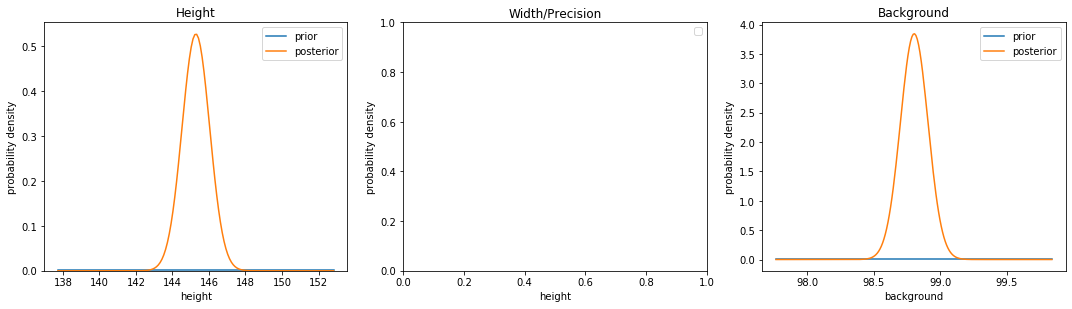

In [38]:
plt.figure(figsize=(15,8))

X = torch.arange(pyro.param("height_loc").item()-pyro.param("height_scale").item()*10, pyro.param("height_loc").item()+pyro.param("height_scale").item()*10,0.1)
#X = torch.arange(190,240,0.1)
prior = dist.HalfNormal(500.)
posterior = dist.Normal(pyro.param("height_loc"), pyro.param("height_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,1)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([h_true, h_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Height")
plt.ylabel("probability density")
plt.xlabel("height")
plt.ylim(0,)
plt.legend()


X = torch.arange(0.5,2.,0.01)
prior = dist.Gamma(1., 0.1)
#posterior = dist.Gamma(pyro.param("width_alpha"), pyro.param("width_beta"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,2)
plt.title("Width/Precision")
plt.ylabel("probability density")
plt.xlabel("height")
plt.legend()


X = torch.arange(pyro.param("background_loc").item()-pyro.param("background_scale").item()*10, pyro.param("background_loc").item()+pyro.param("background_scale").item()*10,0.01)
prior = dist.HalfNormal(1000.)
posterior = dist.Normal(pyro.param("background_loc"), pyro.param("background_scale"))
Y_prior = torch.exp(prior.log_prob(X))
Y_posterior = torch.exp(posterior.log_prob(X))

plt.subplot(2,3,3)
plt.plot(X.cpu().numpy(), Y_prior.data.cpu().numpy(), label="prior")
plt.plot(X.cpu().numpy(), Y_posterior.data.cpu().numpy(), label="posterior")
#plt.plot([b_true, b_true], [0., Y_posterior.max().item()], 'k--', label="true")
plt.title("Background")
plt.ylabel("probability density")
plt.xlabel("background")
plt.legend()






plt.tight_layout()
plt.show()

interactive(children=(Dropdown(description='p1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(de…

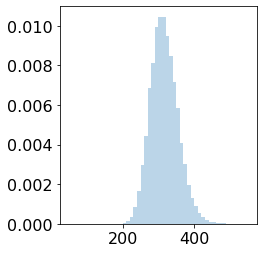

In [224]:
from scipy.stats import poisson, gamma

@interact
def view_noise(p1=np.arange(10), p2=np.arange(10)):

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.hist(gmm.data[z_p[:,0]>0.5].reshape(-1), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.hist(gmm.sample(0).reshape(-1).detach(), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.title("no spot")
    plt.ylabel("density")
    plt.xlabel("intensity")


    plt.subplot(1,3,2)
    plt.hist(gmm.data[z_p[:,1]>0.5].reshape(-1), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.hist(gmm.sample(1).reshape(-1).detach(), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.title("spot")
    plt.ylabel("density")
    plt.xlabel("intensity")
    #plt.legend()

    plt.subplot(1,3,3)
    plt.hist(gmm.data[z_p[:,1]>0.5,p1,p2].reshape(-1), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.hist(gmm.sample(1)[:,p1,p2].reshape(-1).detach(), bins=50, alpha=0.3, density=True, range=(50,550))
    plt.title("{}_{}".format(p1, p2))
    plt.ylabel("density")
    plt.xlabel("intensity")

    plt.tight_layout()
    plt.show()

In [140]:
spot_data = gmm.data[z_p[:,1]>0.5].reshape(-1,100)

sample_data = torch.zeros(100*len(gmm.data),gmm.D,gmm.D)
for i in range(100):
    sample_data[i*len(gmm.data):(i+1)*len(gmm.data),:,:] = gmm.sample(1)
sample_data = sample_data.reshape(-1,100).detach()

spot_data.shape, sample_data.shape

(torch.Size([158, 100]), torch.Size([89200, 100]))

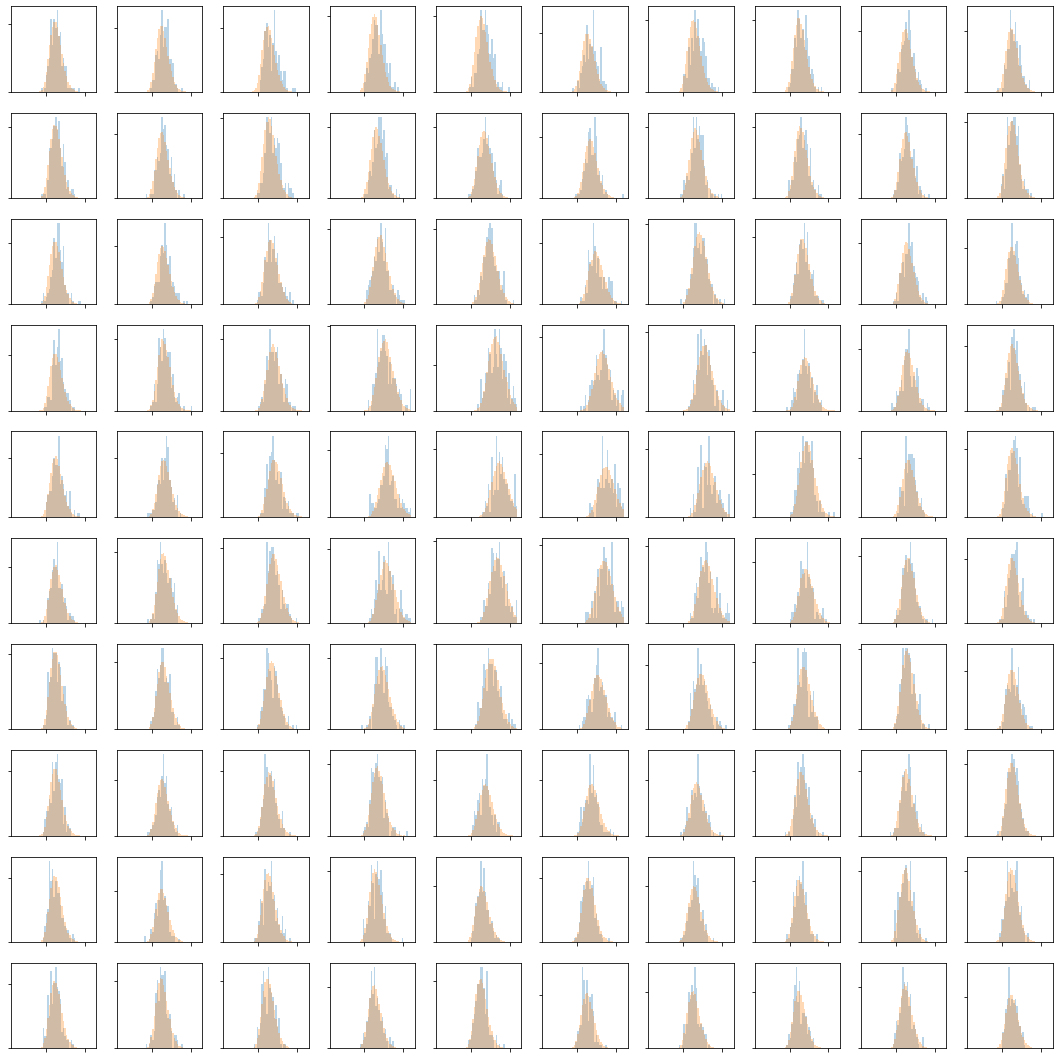

In [141]:
plt.figure(figsize=(15,15))
for i in range(gmm.D**2):
    plt.subplot(gmm.D,gmm.D,i+1)
    plt.hist(spot_data[:,i], bins=50, alpha=0.3, density=True, range=(50,550))
    plt.hist(sample_data[:,i], bins=50, alpha=0.3, density=True, range=(50,550))
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.show()

In [166]:
smd["trace"][aoi].loc[2230:2240].index

Int64Index([2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240], dtype='int64', name='frame')

In [163]:
smd["trace"][aoi]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [190]:
(framelist_df.loc[(framelist_df["aoi"] == 47) & (framelist_df["frame"] == 2707), "detected"] == 1).bool()

True

interactive(children=(IntSlider(value=47, description='aoi', max=141, min=-47), Dropdown(description='frame', …

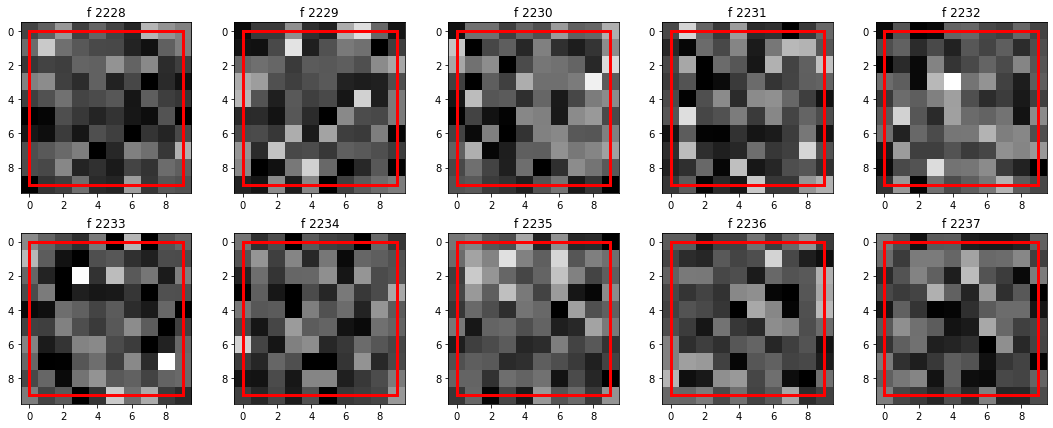

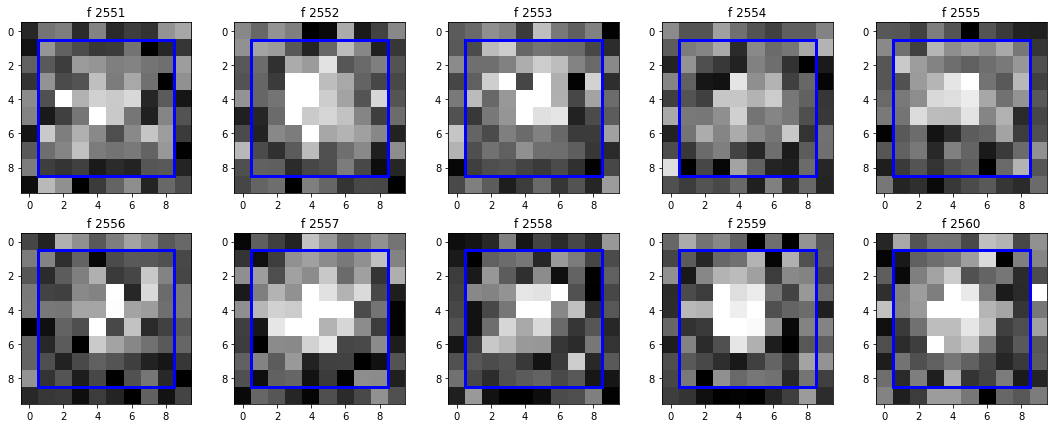

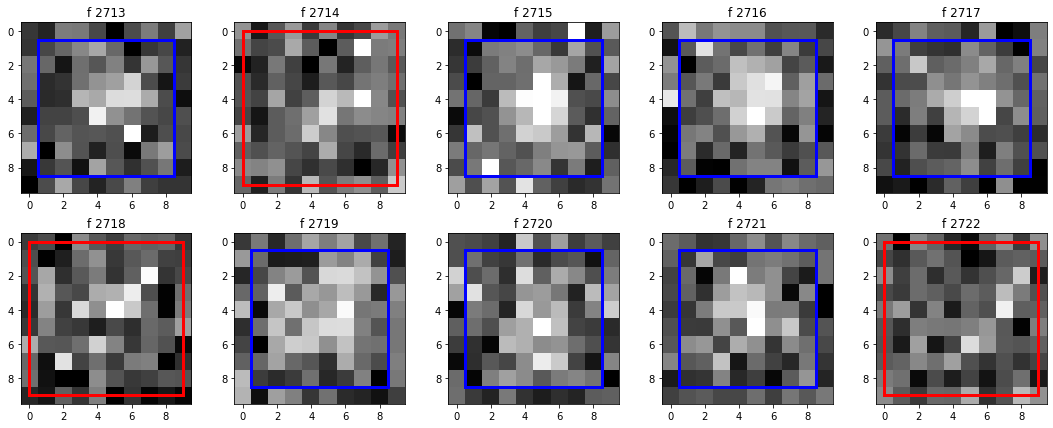

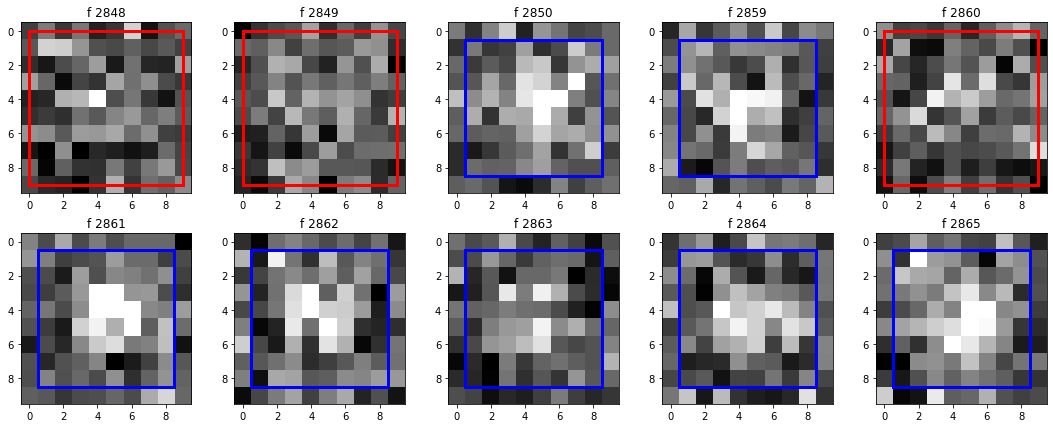

In [259]:
import matplotlib.patches as patches
from copy import copy

rect = patches.Rectangle((0,0),9,9,linewidth=3,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((0.5,0.5),8,8,linewidth=3,edgecolor='b',facecolor='none')

# 11 2252
# 17 2070 22 1181
@interact
def view_aoi(aoi=aoi, frame=smd["trace"][aoi].index):
    frames = smd["trace"][aoi].loc[frame:].index
    #frame = 345
    fig = plt.figure(figsize=(15,6))
    for i in range(10):
        #print(i)
        ax = fig.add_subplot(2,5,i+1)
        plt.title("f {:d}".format(frames[i]))
        vmin = np.percentile(smd["data"][aoi].cpu(), 5)
        vmax = np.percentile(smd["data"][aoi].cpu(), 99)
        plt.imshow(smd["data"][aoi][smd["trace"][aoi].index.get_loc(frames[i])].cpu(), cmap='gray', vmin=vmin, vmax=vmax)
        #plt.scatter(smd["trace"][aoi].at[frames[i], "x"], smd["trace"][aoi].at[frames[i], "y"], marker="x", s=100, c="r")
        if smd["trace"][aoi].at[frames[i],"z1"] > 0.5:
            new_rect = copy(rect)
            ax.add_patch(new_rect)
        if smd["trace"][aoi].at[frames[i],"z2"] > 0.5:
            new_rect = copy(rect2)
            ax.add_patch(new_rect)
        #if (framelist_df.loc[(framelist_df["aoi"] == aoi) & (framelist_df["frame"] == frames[i]), "detected"] == 1).bool():
        #    new_rect = copy(rect2)
        #    ax.add_patch(new_rect)
    plt.tight_layout()
    plt.show()

In [268]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

def surface_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return surf

def wireframe_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.plot_wireframe(x, y, matrix, **kwargs)
    return surf

def scatter_plot (matrix, ax, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    
    
    surf = ax.scatter(x, y, matrix, **kwargs)
    return surf


fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(221, projection='3d')
surf = surface_plot(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2500)].numpy(), ax, cmap=plt.cm.coolwarm)
#surf = scatter_plot(smd["data"][0,97].cpu().numpy(), ax, cmap=plt.cm.coolwarm)
#fig.colorbar(surf)
#frame1 = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_zlim(0,500)
#ax.set_xlabel('X (cols)')
#ax.set_ylabel('Y (rows)')
#ax.set_zlabel('Z (values)')

ax = fig.add_subplot(222, projection='3d')
surf = surface_plot(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2715)].numpy(), ax, cmap=plt.cm.coolwarm)

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_zlim(0,500)

plt.pause(0.1)

In [239]:
smd["data"][aoi][smd["trace"][aoi].index.get_loc(2898)]

tensor([[294., 297., 274., 396., 274., 331., 315., 350., 402., 274.],
        [353., 327., 324., 363., 366., 261., 319., 251., 341., 280.],
        [326., 350., 292., 272., 319., 246., 364., 279., 284., 307.],
        [219., 337., 291., 283., 283., 300., 296., 321., 326., 287.],
        [281., 290., 276., 327., 287., 290., 354., 300., 238., 284.],
        [256., 316., 315., 349., 333., 301., 327., 312., 311., 313.],
        [310., 274., 343., 291., 342., 276., 363., 358., 354., 336.],
        [269., 284., 322., 352., 262., 263., 329., 319., 321., 362.],
        [300., 335., 284., 264., 287., 323., 296., 227., 258., 344.],
        [283., 303., 307., 324., 377., 314., 382., 297., 361., 292.]])

In [240]:
smd["data"][aoi][smd["trace"][aoi].index.get_loc(2903)]

tensor([[304., 335., 335., 347., 307., 317., 319., 294., 302., 288.],
        [381., 301., 335., 312., 321., 299., 313., 304., 319., 266.],
        [308., 276., 293., 352., 303., 290., 275., 330., 392., 288.],
        [342., 320., 388., 302., 247., 307., 313., 331., 357., 409.],
        [322., 339., 378., 249., 280., 313., 297., 291., 263., 391.],
        [281., 321., 310., 334., 321., 275., 305., 370., 280., 328.],
        [345., 321., 346., 308., 309., 265., 295., 339., 317., 351.],
        [309., 327., 278., 288., 220., 327., 351., 267., 338., 307.],
        [377., 289., 342., 240., 322., 287., 345., 258., 310., 354.],
        [367., 271., 297., 316., 264., 276., 294., 225., 374., 283.]])

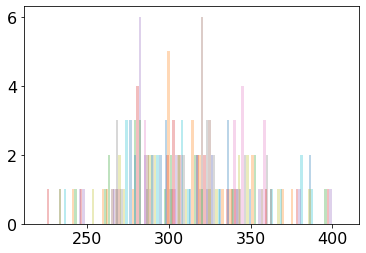

In [232]:
plt.hist(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2898)], alpha=0.3)
plt.hist(smd["data"][aoi][smd["trace"][aoi].index.get_loc(2903)], bins=10, alpha=0.3)
plt.show()

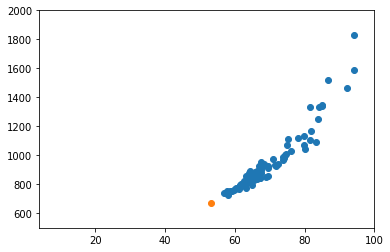

In [362]:
plt.scatter(data[z_p[:,1] > 0.5].mean(dim=0).reshape(-1).numpy(), data[z_p[:,1] > 0.5].var(dim=0).reshape(-1).numpy())
plt.scatter(data[z_p[:,0] > 0.5].mean().reshape(-1).numpy(), data[z_p[:,0] > 0.5].var().reshape(-1).numpy())
#plt.scatter(pyro.param("background_loc").detach(),)
plt.xlim(4,100)
plt.ylim(500,2000)
plt.show()